# Substitution patterns around hotspots

In [1]:
import os
from scipy import signal, stats
import numpy as np

# os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
# import modin.pandas as pd
import pandas as pd

import bisect
import importlib
import warnings
from pathlib import Path
import gc

from tqdm.notebook import trange, tqdm

import ete3
np.random.seed(7)

# import psutil, os
# def mem():
#     return psutil.Process(os.getpid()).memory_info().rss / 1024**3

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from matplotlib_inline.backend_inline import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib import gridspec

#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("white")
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

# My own paired palette replacing the last brown pair with violets
sns.color_palette('Paired').as_hex()
Paired = sns.color_palette(['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c',
                            '#fdbf6f', '#ff7f00', '#cab2d6','#6a3d9a', '#e585cf', '#ad009d'])
#sns.palplot(Paired)

from shared_vars_and_func import *

Monospace font for numbers in tables:

In [3]:
%%html
<style> table { font-variant-numeric: tabular-nums; } </style>

# Load species details

In [4]:
species_details = pd.read_csv('/home/kmt/Birds/faststorage/data/species_details.txt', sep='\t')
species_details.head()

species2014 species              english                latin       group  \
0       PICPU   PICPU     Downy Woodpecker   Picoides pubescens  woodpecker   
1       MERNU   MERNU    Carmine Bee-eater       Merops nubicus  woodpecker   
2       BUCRH   BUCRH  Rhinoceros Hornbill   Buceros rhinoceros  woodpecker   
3       APAVI   APAVI    Bar-tailed Trogon  Apaloderma vittatum  woodpecker   
4       LEPDI   LEPDI        Cuckoo Roller  Leptosomus discolor  woodpecker   

          family male_min male_max female_min female_max   weight  order  \
0    woodpeckers    20,70    32,20      20,70      32,20    26,45     39   
1     bee-eaters    34,00    59,00      34,00      59,00     46,5     38   
2      hornbills  2465,00  2960,00    2040,00    2330,00  2448,75     37   
3        trogons    55,00    55,00      55,00      55,00       55     36   
4  cockoo-roller   160,00   301,00     160,00     301,00    230,5     35   

   order2014  branch_length  
0          1       0.143370  
1          2       0.102957  
2          3       0.099782  
3          4       0.104832  
4          5       0.066956

# All substitution rates around hotspots

The two penguins:

In [5]:
subst_data = pd.read_hdf('../results/subst_data.h5')

In [6]:
plot_df = subst_data.loc[subst_data.species_code.isin(['PYGAD', 'APTFO'])].copy()
# plot_df.species.cat.remove_unused_categories(inplace=True)
plot_df['species'] = plot_df['species'].cat.remove_unused_categories()
plot_df.loc[plot_df.pattern.isin(transitions), 'type'] = 'Transition'
plot_df.loc[~plot_df.pattern.isin(transitions), 'type'] = 'Transversion'
#plot_df.loc[:, 'type'] = pd.Categorical(plot_df.type.values, categories=['Transition', 'Transversion'], ordered=True)
plot_df['type'] = pd.Categorical(plot_df.type.values, categories=['Transition', 'Transversion'], ordered=True)

AttributeError: 'Line2D' object has no property 'errorbar'

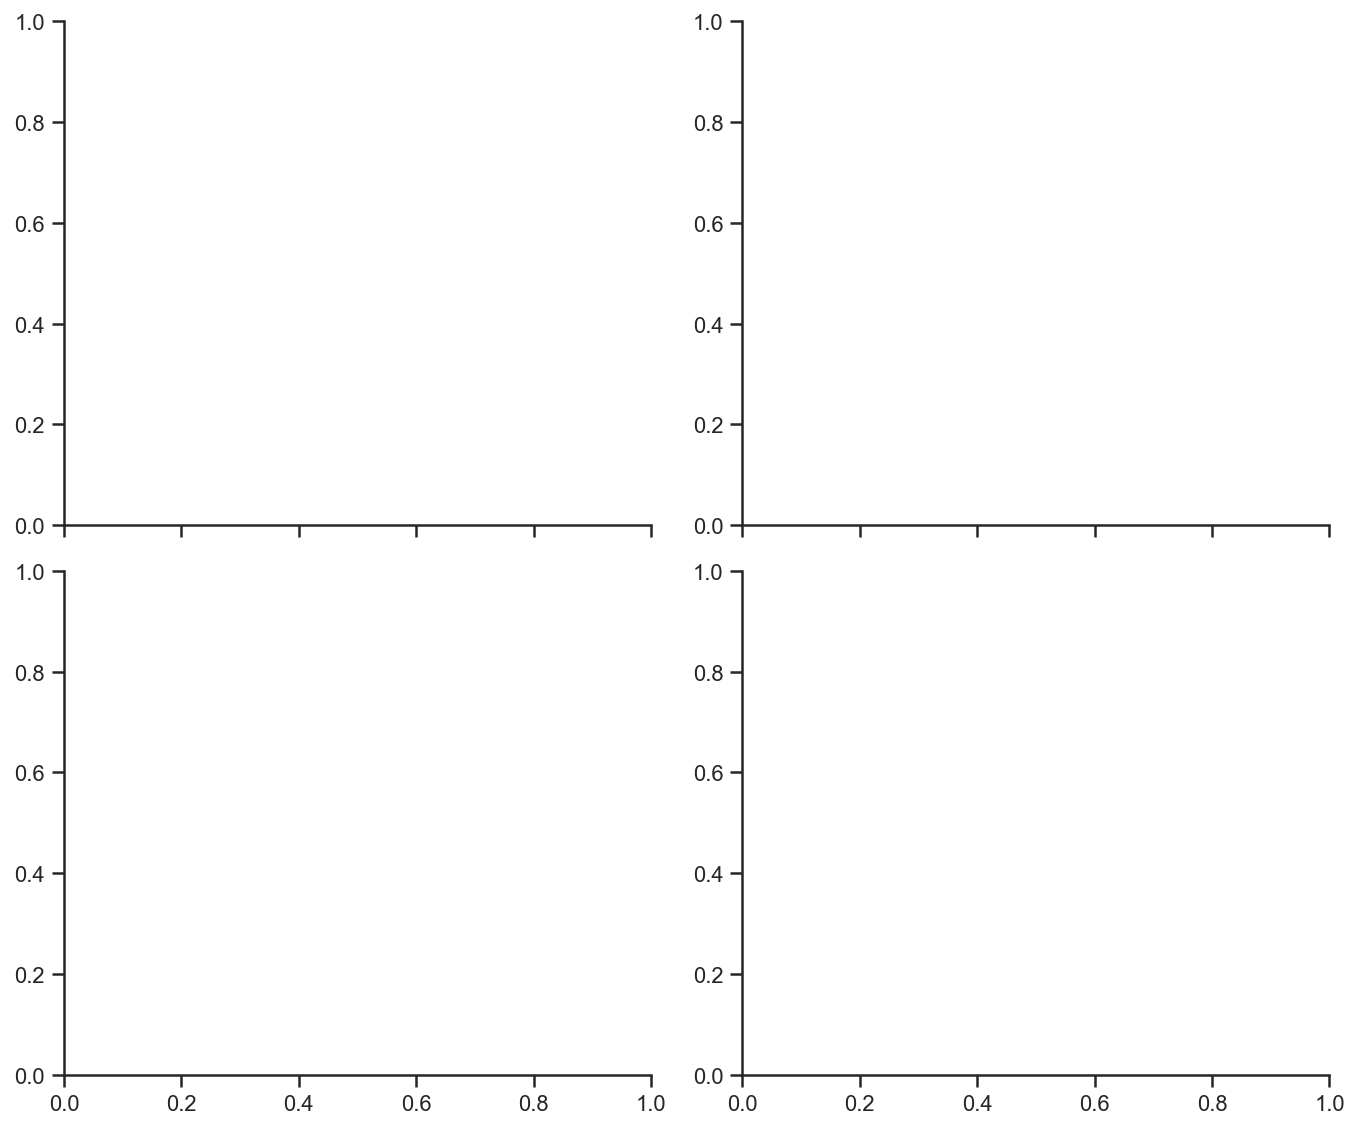

In [7]:
with sns.axes_style('ticks'):
    with sns.color_palette(Paired):
        g = sns.FacetGrid(plot_df,
                          col='species', row='type', hue='pattern',
                          legend_out=True, margin_titles=True,
                          sharey=False, height=4, aspect=1.2)
        g.map(sns.lineplot, 'bin', 'rate', errorbar=None).add_legend()
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        plt.savefig(figures_path / 'all_subst_rates_across_hotspots_penguins.pdf')                                            

Same but requiring that the number of aligned bases is at least 900

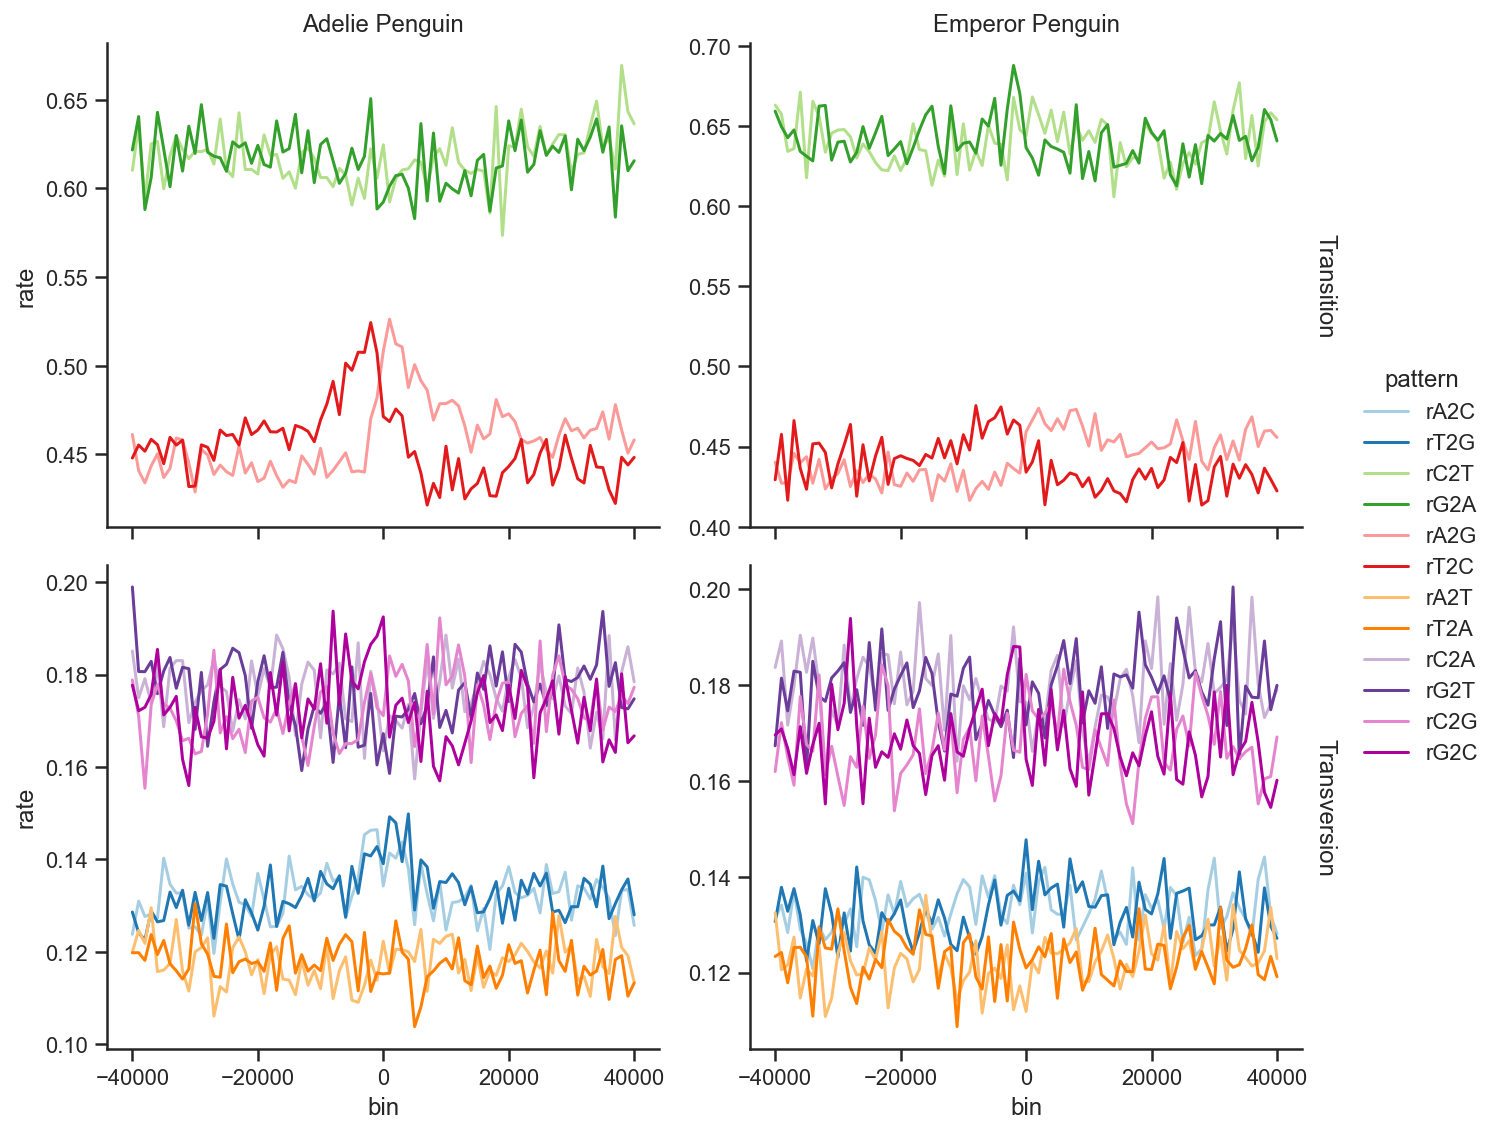

In [8]:
with sns.axes_style('ticks'):
    with sns.color_palette(Paired):
        g = sns.FacetGrid(plot_df.loc[plot_df.nr_aligned >= 900],
                          col='species', row='type', hue='pattern',
                          legend_out=True, margin_titles=True,
                          sharey=False, height=4, aspect=1.2)
        g.map(sns.lineplot, 'bin', 'rate', ci=None).add_legend()
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        plt.savefig(figures_path / 'all_subst_rates_across_hotspots_penguins_min900bases.pdf')                                                    

Note the difference in y-axis in the plots above. It seems to be the windows with fewer than 900 bases aligned (300-900) are the ones responsible for the large peak right at the center. This is probably a biological signal: windows with higher recombination have more structural variation. What is more important is that the AT conservative substututions do not seem to be affected. This suggests that the lower number of aligned bases in some windows is not due to misalignment as this would inflate all the rates at the hotspot center where there are fewest aligned bases.

Plot all rates for each species:

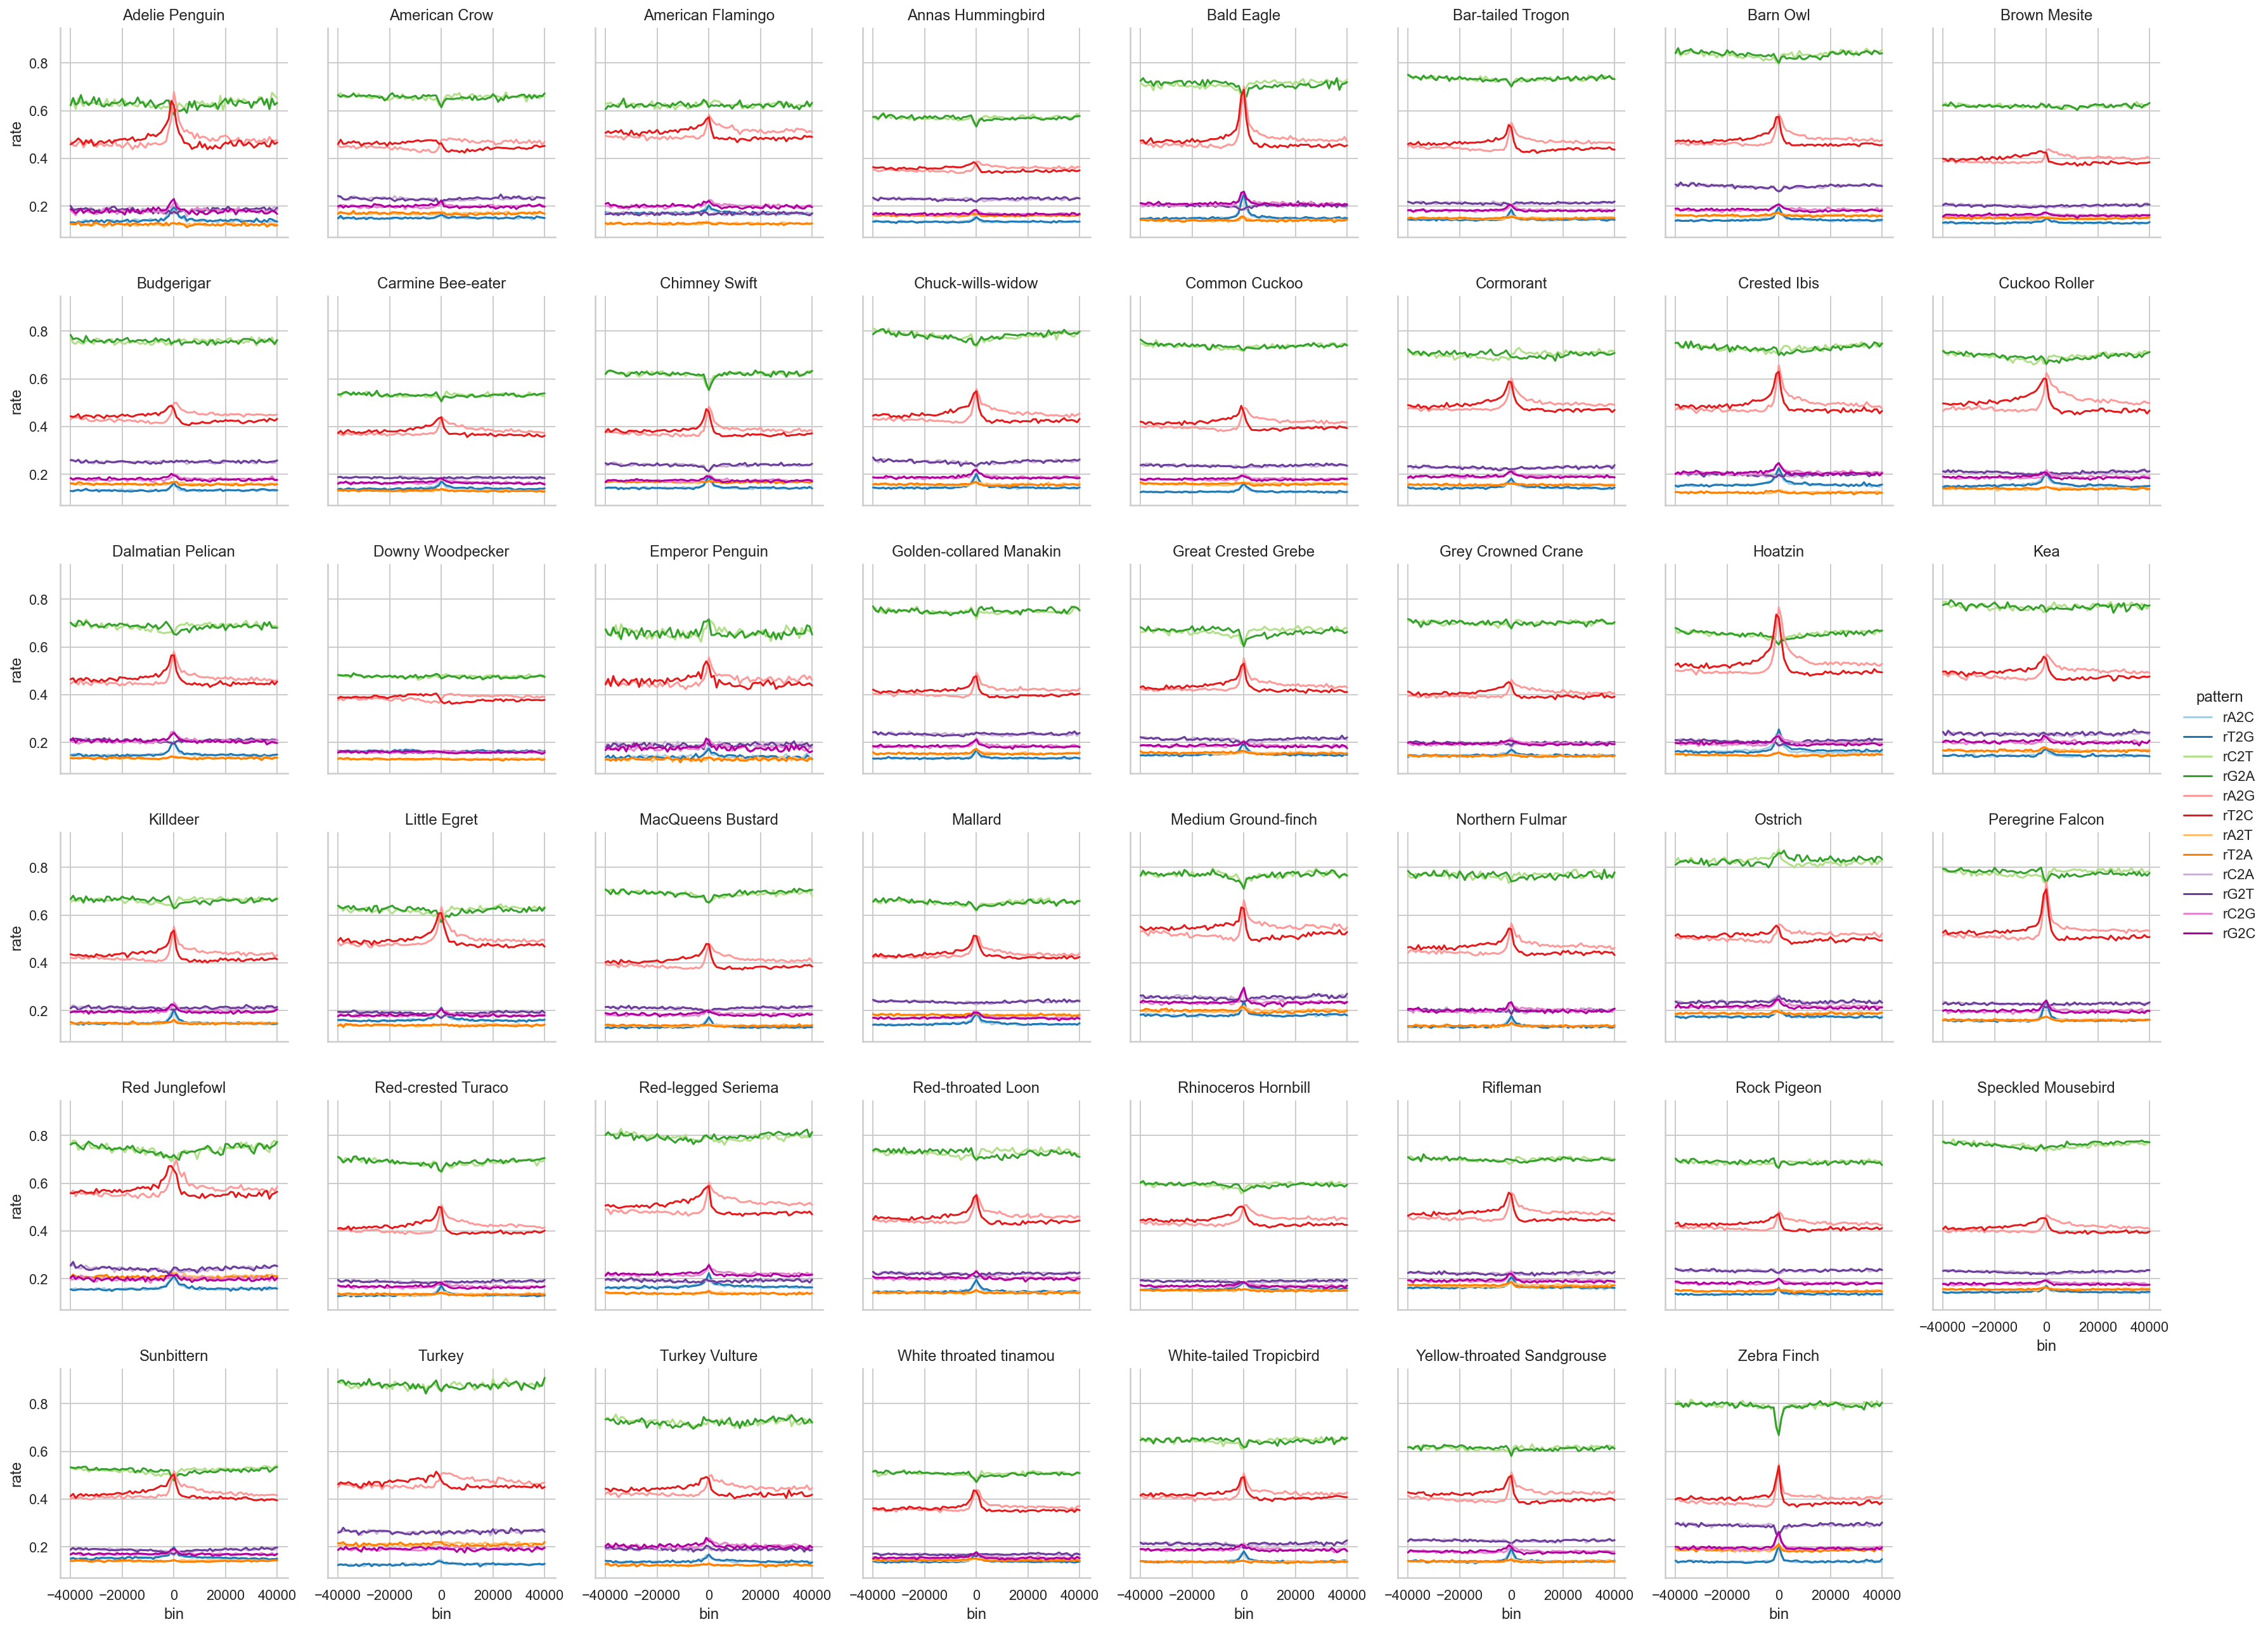

In [9]:
with sns.axes_style('whitegrid'):
    with sns.color_palette(Paired):
        g = sns.FacetGrid(subst_data,
                          col='species', hue='pattern',
                          col_wrap=8, sharey=True)#, ylim=(0,1.2))
        g.map(sns.lineplot, 'bin', 'rate', ci=None).add_legend()
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}') ;
        plt.savefig(figures_path / 'all_subst_rates_across_hotspots_indiv_species.pdf')                                                    

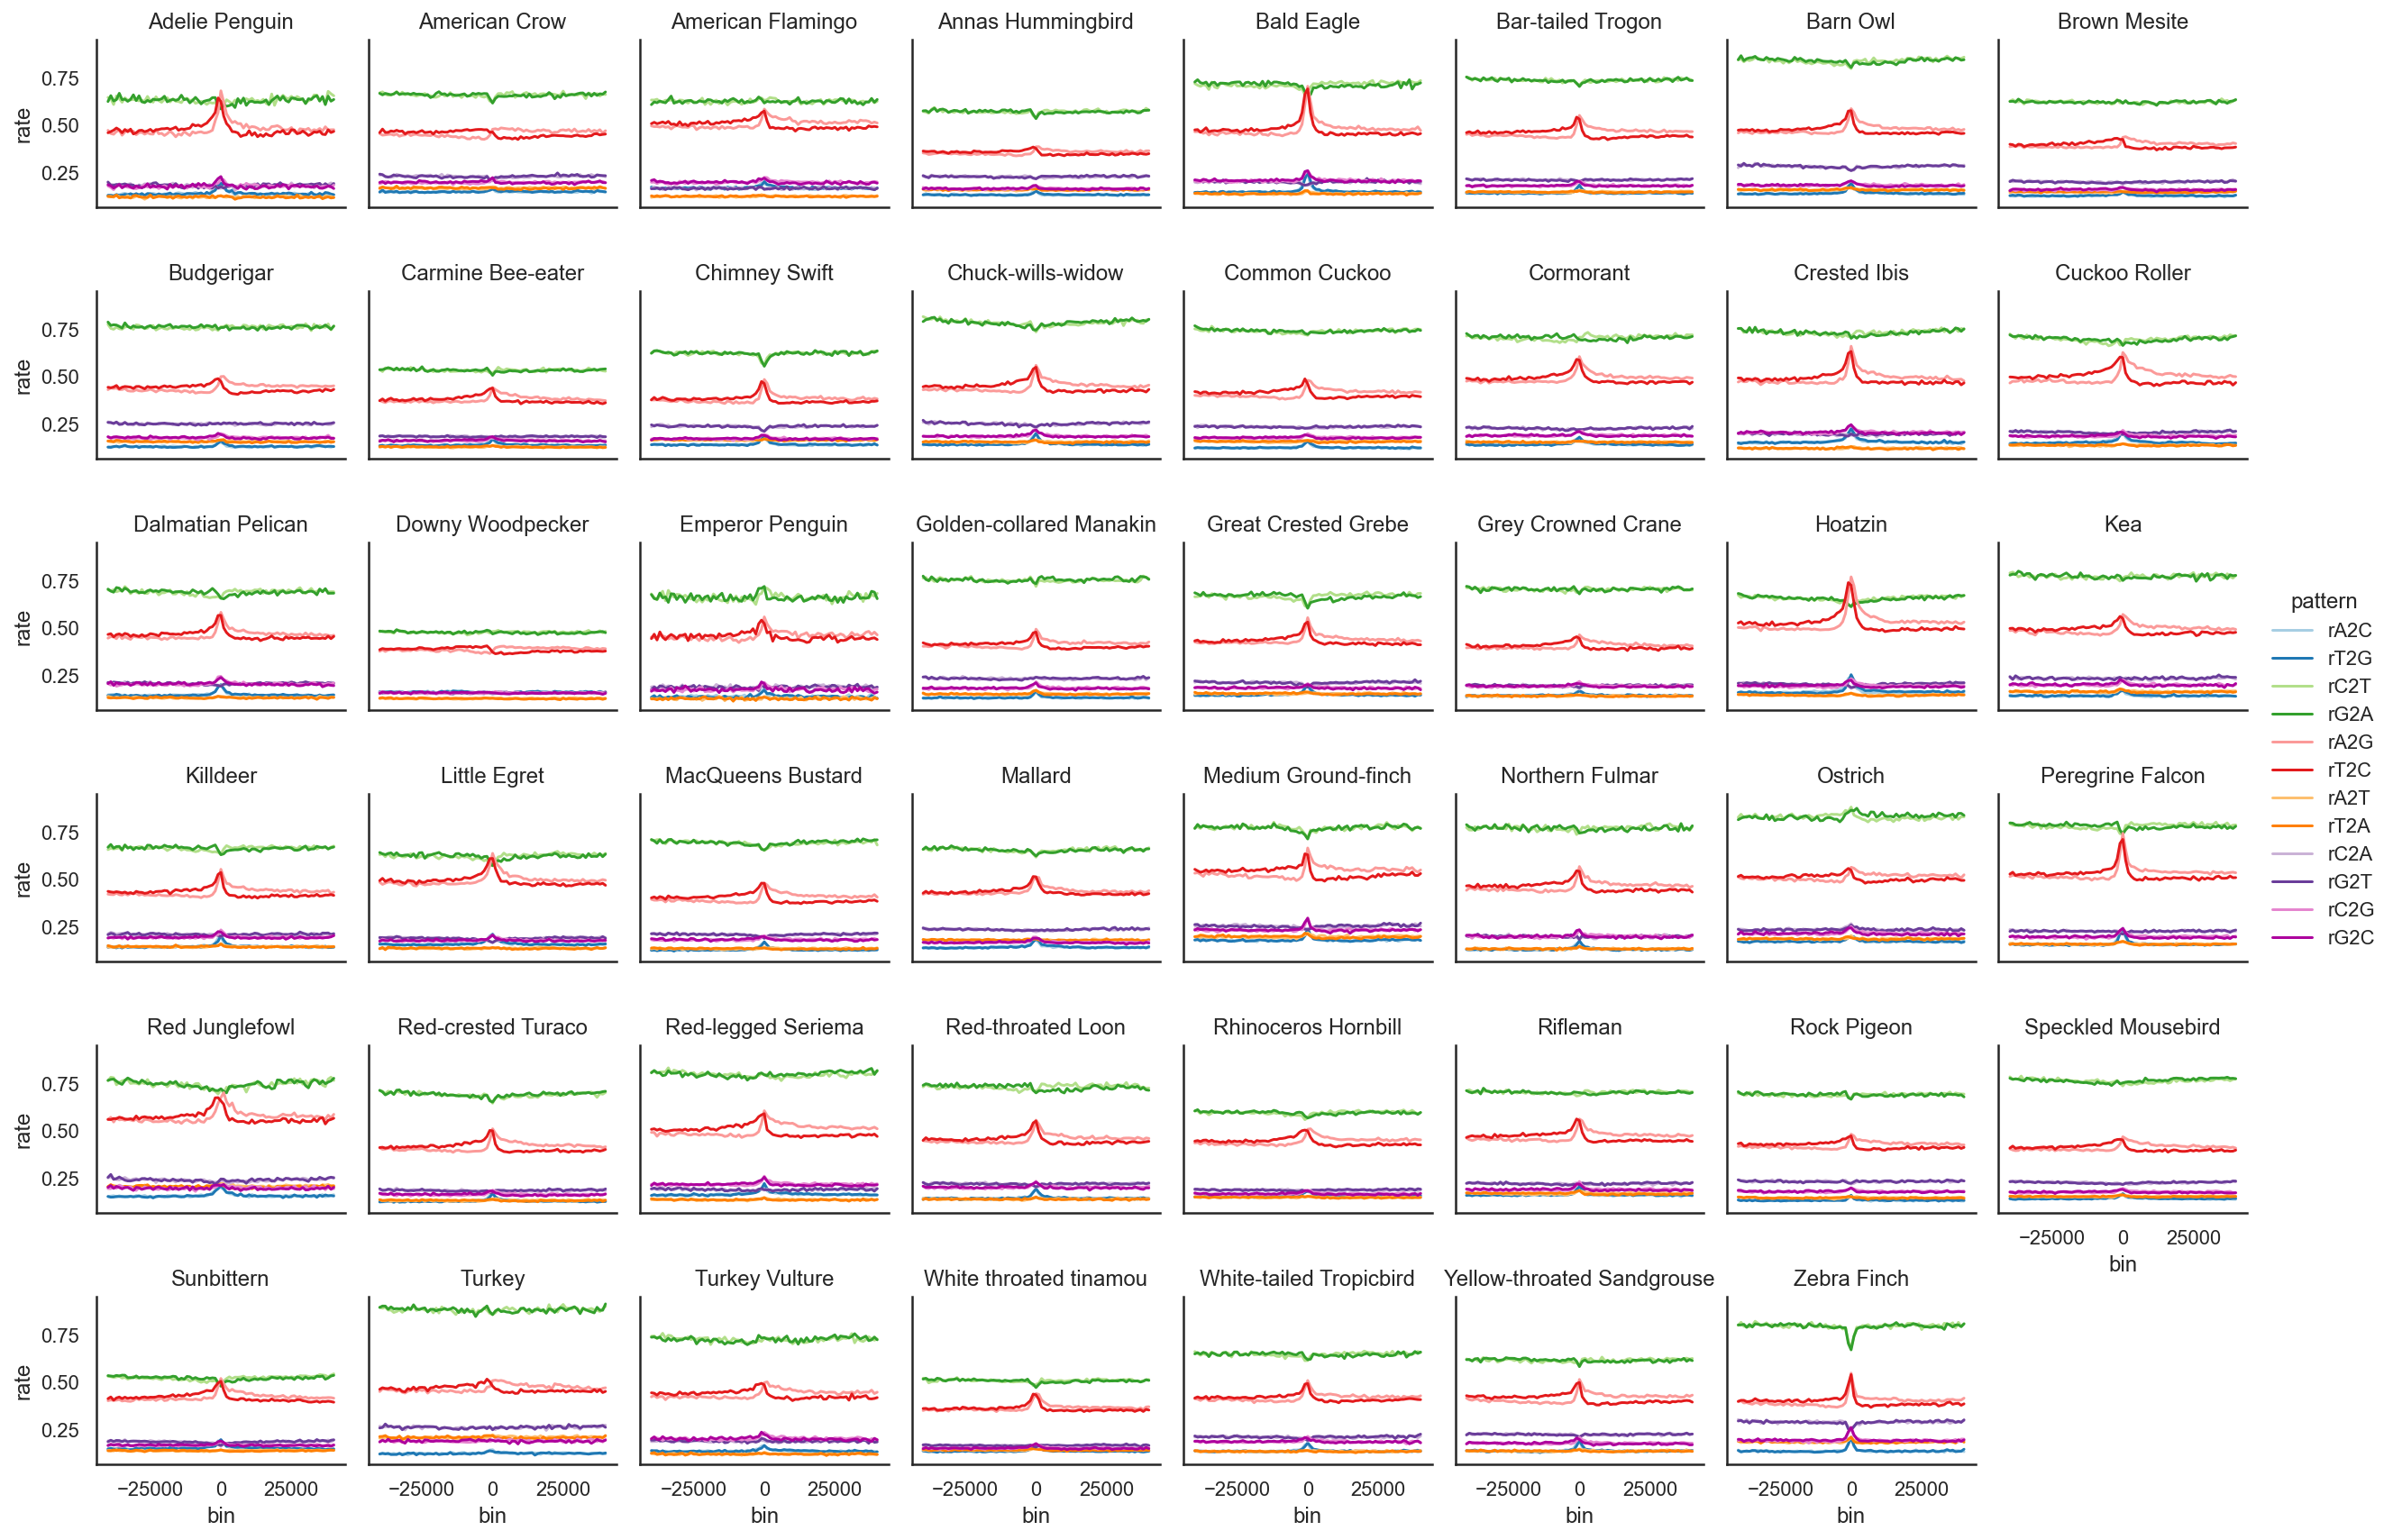

In [10]:
with sns.axes_style('white'):
    with sns.color_palette(Paired):
        g = sns.FacetGrid(subst_data,
                          col='species', hue='pattern',
                          col_wrap=8, sharey=True,
                          height=2, aspect=1.1)#, ylim=(0,1.2))
        g.map(sns.lineplot, 'bin', 'rate', ci=None).add_legend()
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}') ;
        plt.savefig(figures_path / 'poster_all_subst_rates_across_hotspots_indiv_species.pdf')

## Substitution rates at center of hotspots relative to flanks

In [11]:
subst_flank = subst_data.loc[(subst_data.bin.abs() < 40000) & (subst_data.bin.abs() >= 20000)].groupby(['species', 'pattern']).rate.mean()
subst_center = subst_data.loc[subst_data.bin == 0].groupby(['species', 'pattern']).rate.mean()
subst_ratios = (subst_center / subst_flank).reset_index().rename(columns={'rate': 'ratio'})
subst_table = subst_ratios.pivot(index='species', columns='pattern', values='ratio').rename(columns=str).reset_index()
subst_table.head()

pattern            species      rA2C      rT2G      rC2T      rG2A      rA2G  \
0           Adelie Penguin  1.365830  1.424862  0.948059  0.918772  1.452469   
1            American Crow  1.119799  1.091665  0.939212  0.931810  1.043007   
2        American Flamingo  1.138639  1.203479  1.005168  0.986593  1.162187   
3        Annas Hummingbird  1.156982  1.146304  0.937082  0.933231  1.087499   
4               Bald Eagle  1.654058  1.707197  0.946628  0.922632  1.505907   

pattern      rT2C      rA2T      rT2A      rC2A      rG2T      rC2G      rG2C  
0        1.337908  1.063567  1.041224  0.909803  0.953365  1.214755  1.293528  
1        1.019233  1.040732  1.006041  0.886609  0.908448  1.073520  1.127875  
2        1.153174  1.038578  1.041068  0.989474  0.964848  1.141829  1.116101  
3        1.068100  1.036344  1.030992  0.953867  0.941826  1.077045  1.104654  
4        1.490004  1.085574  1.118080  0.909286  0.915152  1.260314  1.258788

In [12]:
plot_df = subst_table.melt(id_vars=['species'], var_name='pattern', value_name='ratio')
plot_df.head()

species pattern     ratio
0     Adelie Penguin    rA2C  1.365830
1      American Crow    rA2C  1.119799
2  American Flamingo    rA2C  1.138639
3  Annas Hummingbird    rA2C  1.156982
4         Bald Eagle    rA2C  1.654058

In [13]:
subst_table.head()

pattern            species      rA2C      rT2G      rC2T      rG2A      rA2G  \
0           Adelie Penguin  1.365830  1.424862  0.948059  0.918772  1.452469   
1            American Crow  1.119799  1.091665  0.939212  0.931810  1.043007   
2        American Flamingo  1.138639  1.203479  1.005168  0.986593  1.162187   
3        Annas Hummingbird  1.156982  1.146304  0.937082  0.933231  1.087499   
4               Bald Eagle  1.654058  1.707197  0.946628  0.922632  1.505907   

pattern      rT2C      rA2T      rT2A      rC2A      rG2T      rC2G      rG2C  
0        1.337908  1.063567  1.041224  0.909803  0.953365  1.214755  1.293528  
1        1.019233  1.040732  1.006041  0.886609  0.908448  1.073520  1.127875  
2        1.153174  1.038578  1.041068  0.989474  0.964848  1.141829  1.116101  
3        1.068100  1.036344  1.030992  0.953867  0.941826  1.077045  1.104654  
4        1.490004  1.085574  1.118080  0.909286  0.915152  1.260314  1.258788

In [14]:
order=['rA2C', 'rT2G', 'rA2G', 'rT2C', 'rC2G', 'rG2C', 'rA2T', 'rT2A', 'rC2T', 'rG2A', 'rC2A', 'rG2T']

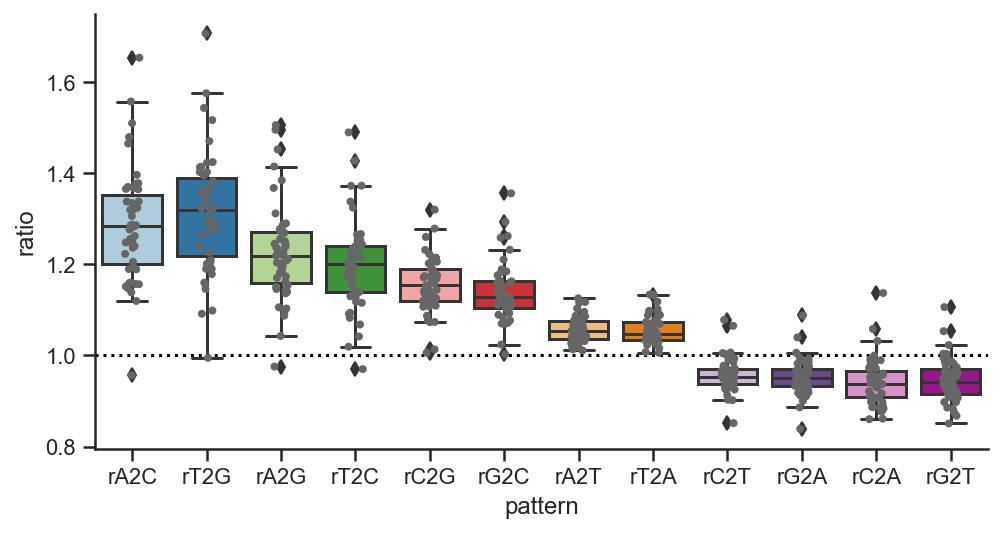

In [15]:
with sns.color_palette(Paired):
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(figsize=(8, 4))
        sns.stripplot(x="pattern", y="ratio", jitter=True, data=plot_df, 
                      color='#666666', ax=ax, size=4, order=order)
        sns.boxplot(x="pattern", y="ratio", data=plot_df, ax=ax, order=order)
        sns.despine()
        plt.axhline(y=1, linestyle='dotted', color='black', zorder=0)
        plt.savefig(figures_path / 'all_subst_rates_boxplot.pdf')                                                    

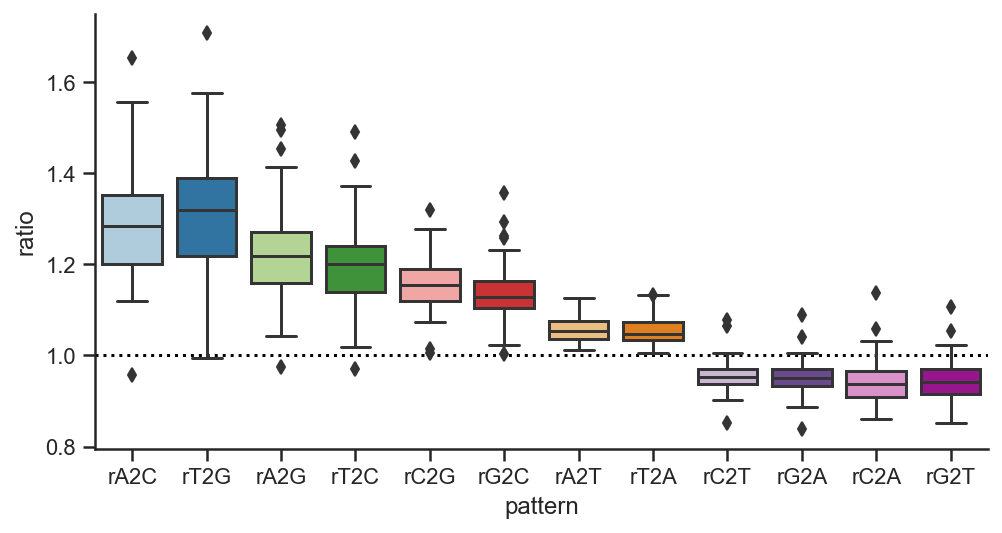

In [16]:
with sns.color_palette(Paired):
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(figsize=(8, 4))
        sns.boxplot(x="pattern", y="ratio", data=plot_df, ax=ax, order=order)
        sns.despine()
        plt.axhline(y=1, linestyle='dotted', color='black', zorder=0)
        plt.savefig(figures_path / 'poster_all_subst_rates_boxplot.pdf')   

It looks like the GC conservative substitutionr rates are symmetric, but that there is a slight skew in the non-conservative ones. E.g. rA2C < rT2G.

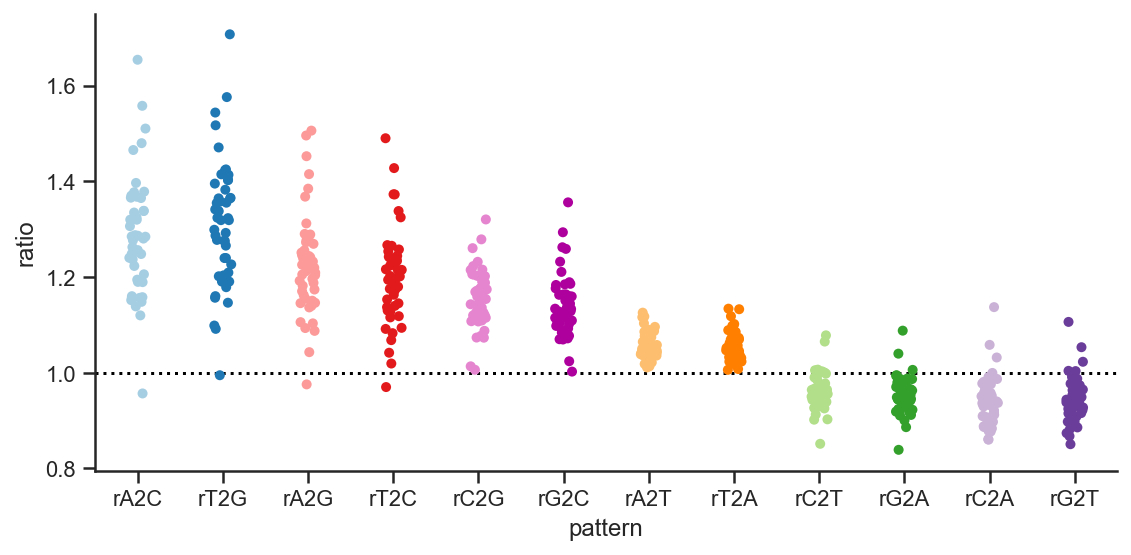

In [17]:
with sns.color_palette(Paired):
    with sns.axes_style('ticks'):
        g = sns.catplot(x="pattern", y="ratio", #col='species',# col_wrap=5, 
                      jitter=True, data=plot_df, hue='pattern',
                      height=4, aspect=2,
                      order=order
                   )
        g.map(plt.axhline, y=1, linestyle='dotted', color='black', zorder=0)
        plt.savefig(figures_path / 'all_subst_rates_stripplot.pdf')                                                            

Individual species with error bars:

In [18]:
indiv_subst_flank = subst_data.loc[(subst_data.bin.abs() < 40000) & (subst_data.bin.abs() >= 20000)].groupby(['species', 'pattern', 'hotspot_center']).rate.mean()
indiv_subst_flank.name = 'rate_flank'
indiv_subst_center = subst_data.loc[subst_data.bin == 0].groupby(['species', 'pattern', 'hotspot_center']).rate.mean()
indiv_subst_center.name = 'rate_center'

In [19]:
len(set([x[2] for x in indiv_subst_flank.index.values])), len(set([x[2] for x in indiv_subst_center.index.values]))


(2816, 2640)

In [20]:
# subst_table = pd.concat([indiv_subst_flank, indiv_subst_center], axis=1).reset_index()
# subst_table.head()

In [21]:
# def mean_ratio(df):
#     return (df.rate_center.mean() / df.rate_flank.mean()).mean()

# def std_ratio(df):
#     bootstraps = list()
#     for i in range(1000):
#         sample_df = df.sample(frac=1, replace=True)
#         bootstraps.append(sample_df.rate_center.mean() / sample_df.rate_flank.mean())
#     bootstraps = pd.Series(bootstraps)
# #     return pd.DataFrame(dict(mean=[bootstraps.mean()], std=[bootstraps.std()]))
#     return bootstraps.std()

In [22]:
indiv_subst_ratios = (indiv_subst_center / indiv_subst_flank).reset_index().rename(columns={0: 'ratio'})
# ratios = (center / flank).reset_index().rename(columns={'rate': 'ratio'})#.dropna()
indiv_subst_ratios.head()

species pattern  hotspot_center     ratio
0  Adelie Penguin    rA2C           86463  0.000000
1  Adelie Penguin    rA2C          121019  0.000000
2  Adelie Penguin    rA2C          147199  1.864197
3  Adelie Penguin    rA2C          204503  0.000000
4  Adelie Penguin    rA2C          274274       NaN

In [23]:
indiv_subst_ratios.loc[indiv_subst_ratios.ratio.isin([np.inf, -np.inf])].hotspot_center.unique()

array([ 11839653,  19021078,  47803031,  93897552,  15510601,  27047670,
        35852068,  15555717,  27679149,  48269062,  25477014,  26250012,
        49877025,  56670515, 108762128,    147199,  11700977,  15238560,
        24354215,  46629022,  84257543,  15800539,  33471179,    328011,
        15602012,  35808545,  47864485,  50848043,  50894086,  20429919,
        25450510,  33339013,    639026,   6741026,  88465389,  22726605,
        37688399,  48051017,  94841007,  17506039, 129007239,  22244549,
        56572002,   6673515, 126594707,  47844007,  90761518,  61484304,
        40145060,  88417142,   9574573,  15796013,  79524040,   9946044,
        19537523,  57535531,  85522067,  17111183,  30704281,  55148017,
        36005539,  67492530,  20634011,  74736548,  76671505, 108865017,
        24043537,  84200614,  60211073,  10147503,  78775573,  48889053,
        88516504,  25794554,  99650002,  21547524])

# TODO: figure out  how to handle infs

In [24]:
plot_df = indiv_subst_ratios.replace([np.inf, -np.inf], np.nan).dropna()
plot_df.head()

species pattern  hotspot_center     ratio
0  Adelie Penguin    rA2C           86463  0.000000
1  Adelie Penguin    rA2C          121019  0.000000
2  Adelie Penguin    rA2C          147199  1.864197
3  Adelie Penguin    rA2C          204503  0.000000
5  Adelie Penguin    rA2C          291046  3.668226

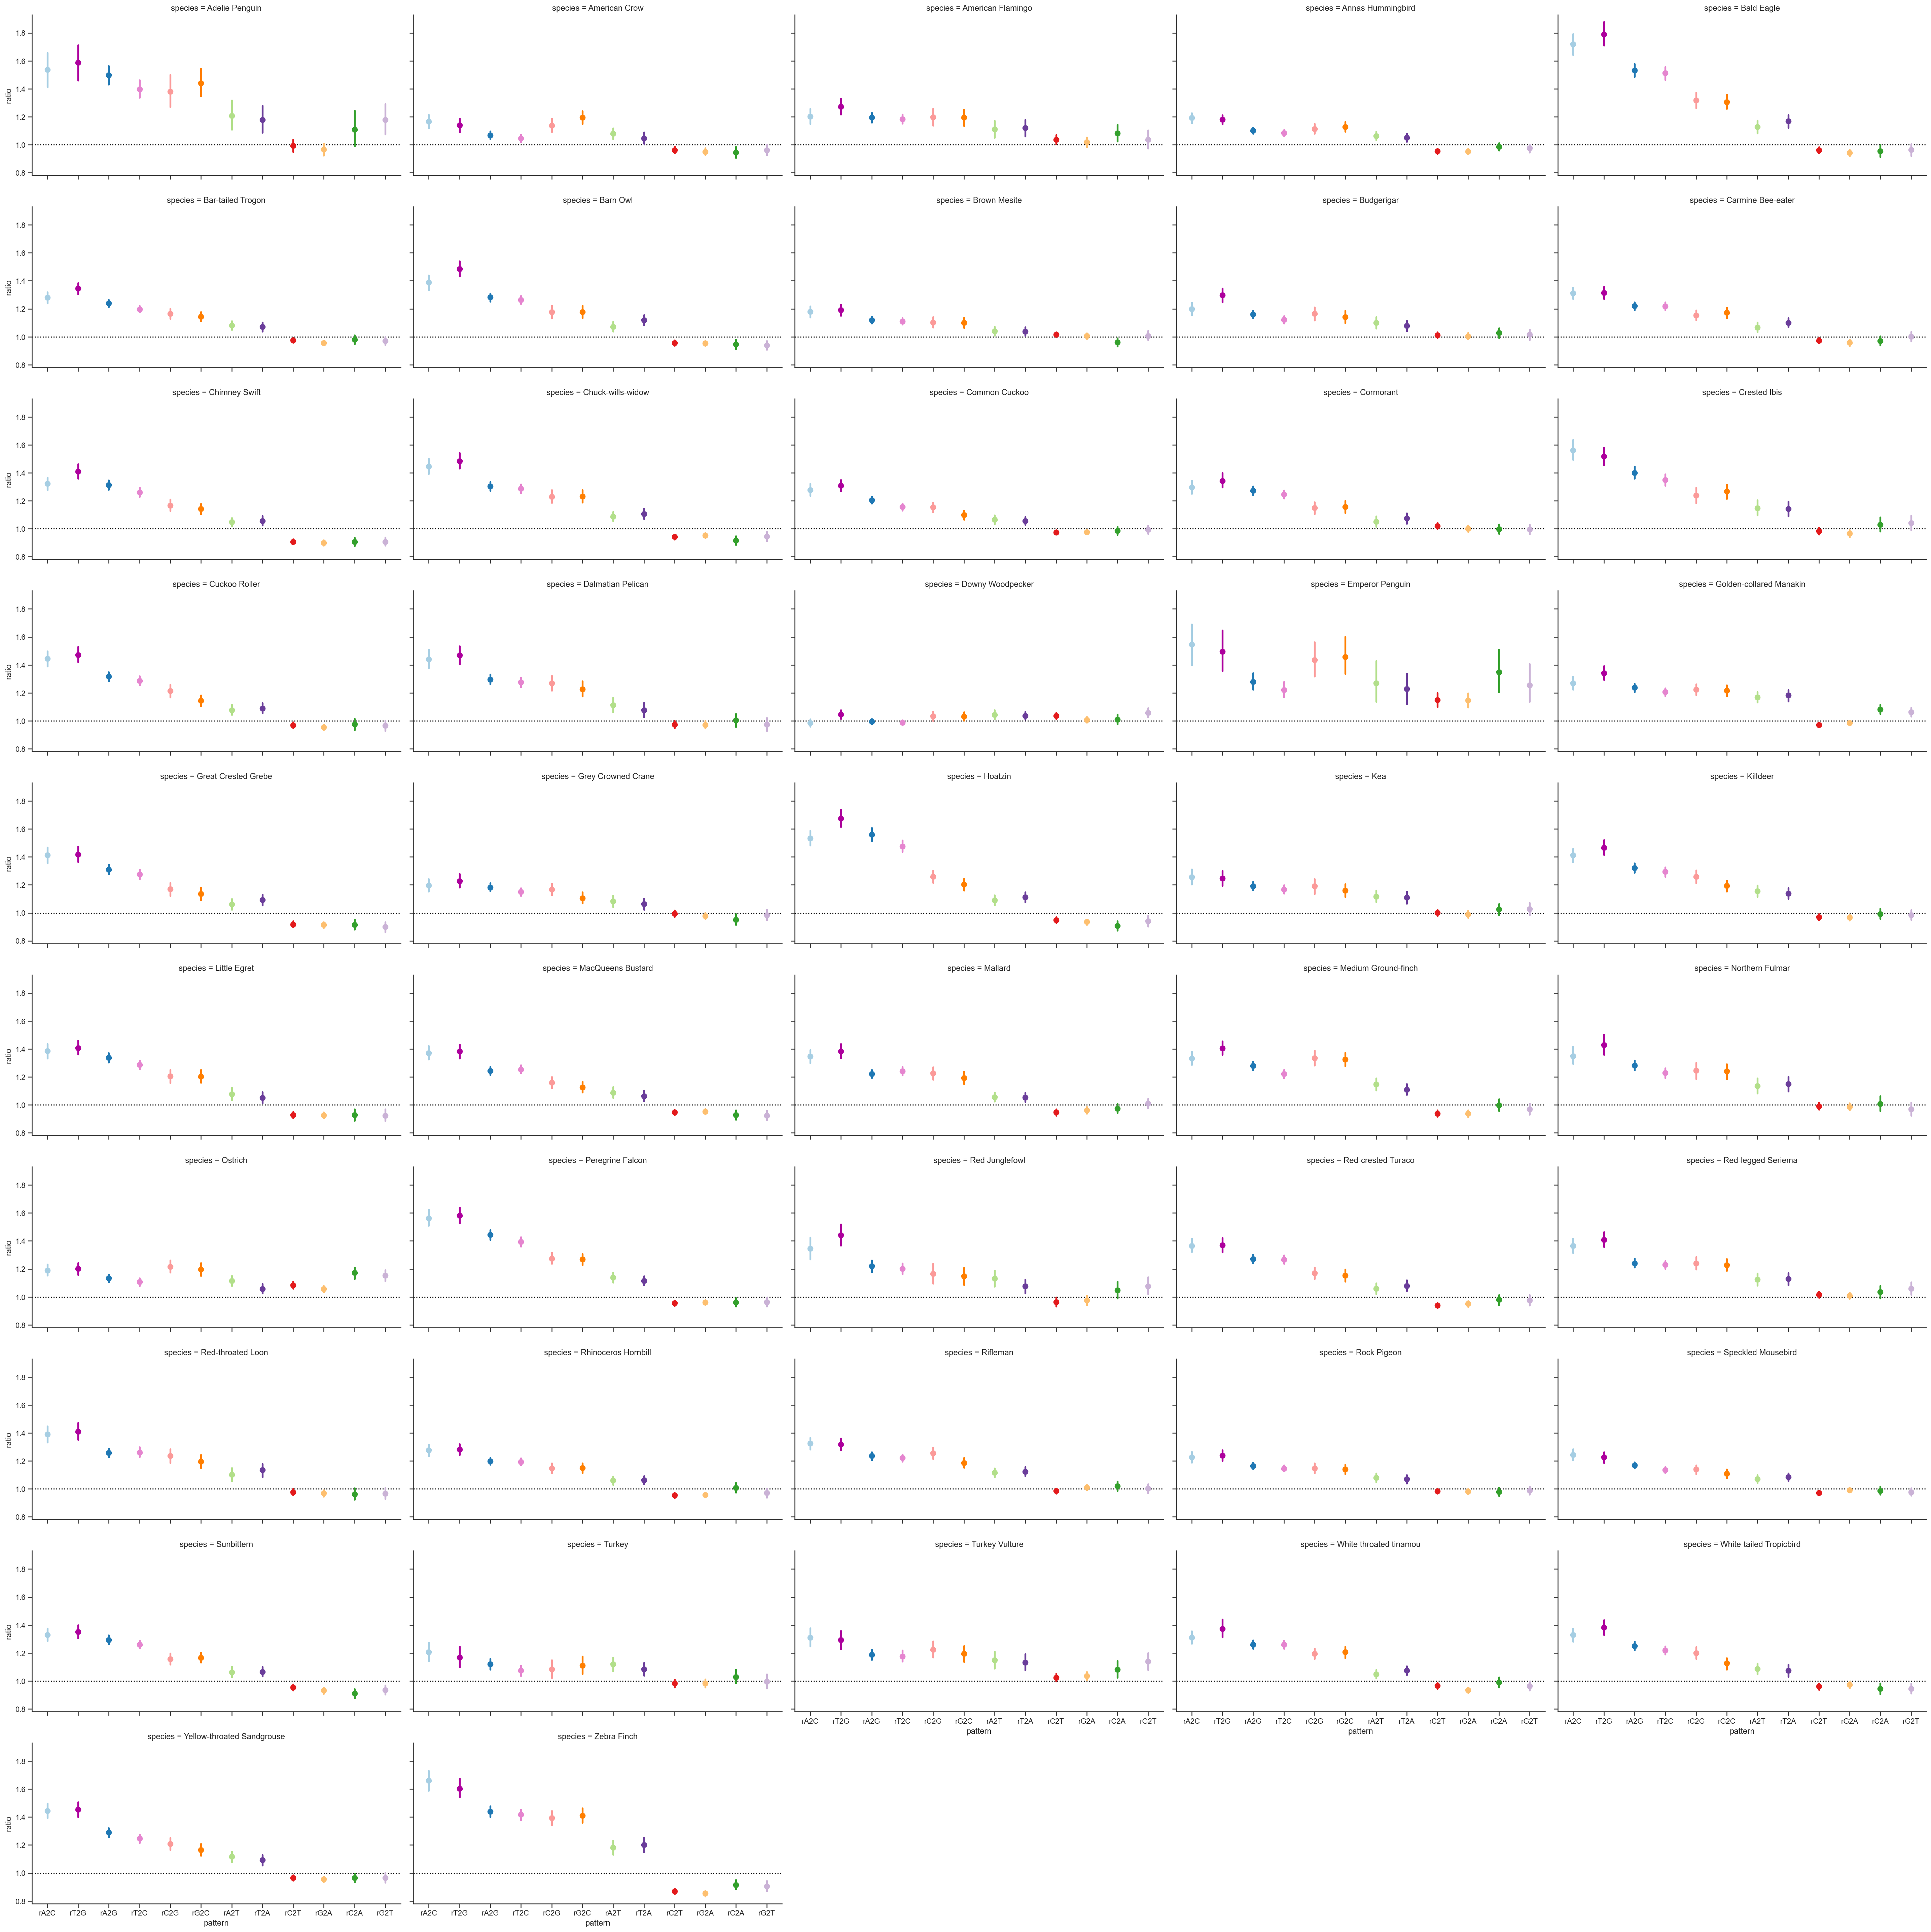

In [25]:
with sns.color_palette(Paired):
    with sns.axes_style('ticks'):
        g = sns.catplot(x="pattern", y="ratio", col='species', col_wrap=5, 
                        kind='point', join=False,
                        data=plot_df,
                        hue='pattern', scale=1,
                        height=4, aspect=2,
                        order=order
                   )
        g.map(plt.axhline, y=1, linestyle='dotted', color='black', zorder=0)
        
        plt.savefig(figures_path / 'all_mean_subst_rates_indiv_species.pdf')                                                    
        
#        plt.errorbar(x, y + 3, yerr=yerr, label='both limits (default)')


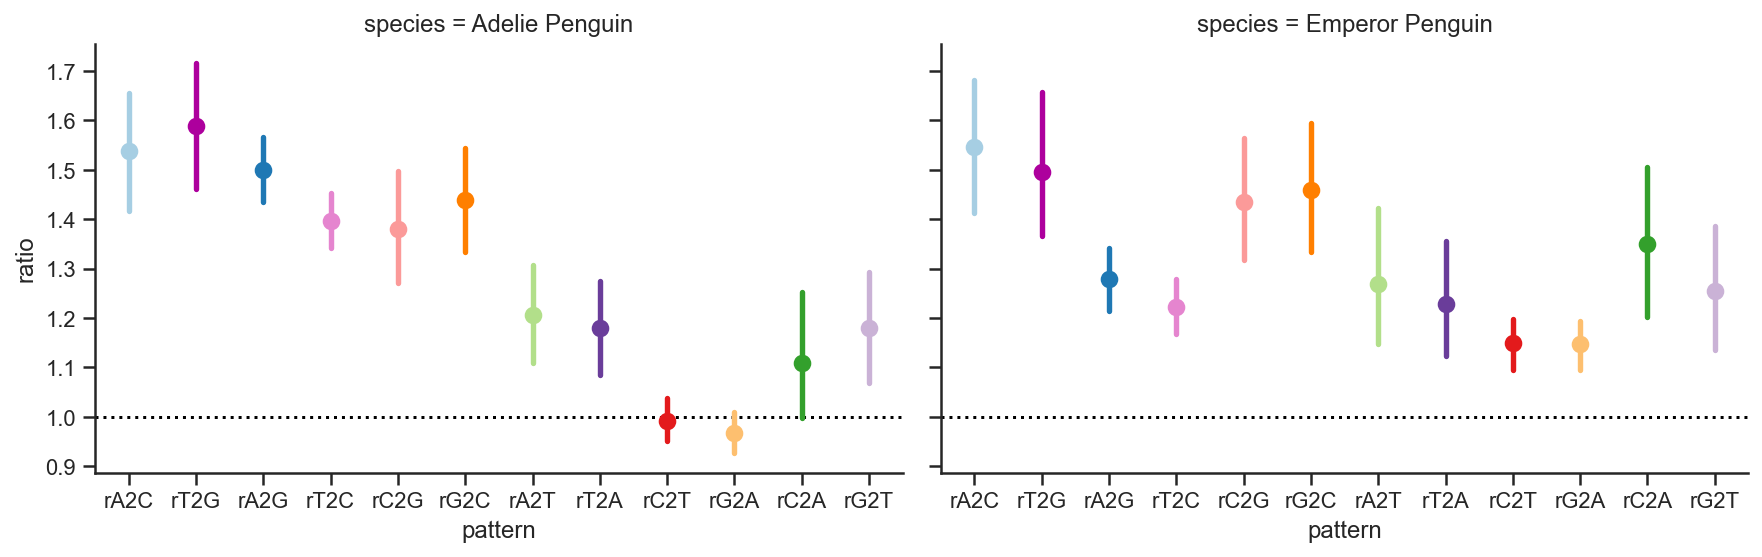

In [26]:
#plot_df_subset = plot_df.loc[plot_df.species_code.isin(['APTFO', 'PYGAD'])]
plot_df_subset = plot_df.loc[plot_df.species.isin(['Adelie Penguin', 'Emperor Penguin'])]
#plot_df_subset.species.cat.remove_unused_categories(inplace=True)

#plot_df_subset = plot_df_subset.loc[~plot_df_subset.ratio.isnull()]

with sns.color_palette(Paired):
    with sns.axes_style('ticks'):
        g = sns.catplot(x="pattern", y="ratio", col='species', col_wrap=5, 
                      data=plot_df_subset,
                      hue='pattern', scale=1, kind='point',
                      height=4, aspect=1.5,
                      order=order
                   )
        g.map(plt.axhline, y=1, linestyle='dotted', color='black', zorder=0)
        plt.savefig(figures_path / 'all_mean_subst_rates_penguins.pdf')                                                    
        

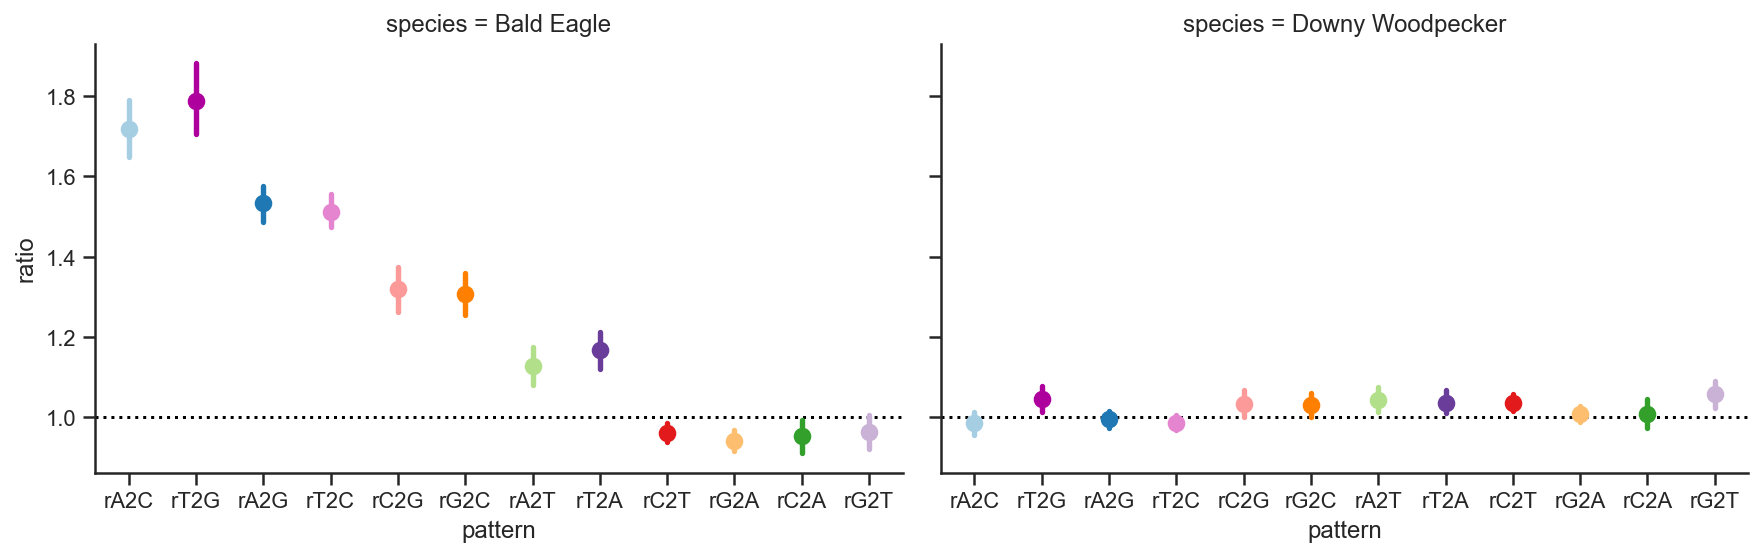

In [27]:
#plot_df_subset = plot_df.loc[plot_df.species_code.isin(['APTFO', 'PYGAD'])]
plot_df_subset = plot_df.loc[plot_df.species.isin(['Downy Woodpecker', 'Bald Eagle'])]
#plot_df_subset.species.cat.remove_unused_categories(inplace=True)

#plot_df_subset = plot_df_subset.loc[~plot_df_subset.ratio.isnull()]

with sns.color_palette(Paired):
    with sns.axes_style('ticks'):
        g = sns.catplot(x="pattern", y="ratio", col='species', col_wrap=5, 
                      data=plot_df_subset,
                      hue='pattern', scale=1, kind='point',
                      height=4, aspect=1.5,
                      order=order
                   )
        g.map(plt.axhline, y=1, linestyle='dotted', color='black', zorder=0)
        plt.savefig(figures_path / 'all_mean_subst_rates_woodpecker_ostrich.pdf')                                                    
        

In [28]:
# plot_df = pd.DataFrame()
# for a, b in paired_patterns:
#     plot_df[f'{a}+{b}'] = (df[a] + df[b]) / 2
# plot_df.head()
# plot_df = plot_df.melt(id_vars=['species'], var_name='pattern', value_name='ratio')
# plot_df.head()

plot_df = pd.DataFrame()
plot_df['species'] = subst_table['species']
for a, b in paired_patterns:
    plot_df[f'{a}+{b}'] = (subst_table[a] + subst_table[b]) / 2

plot_df = plot_df.melt(id_vars=['species'], var_name='pattern', value_name='ratio')
plot_df.head()

species    pattern     ratio
0     Adelie Penguin  rT2G+rA2C  1.395346
1      American Crow  rT2G+rA2C  1.105732
2  American Flamingo  rT2G+rA2C  1.171059
3  Annas Hummingbird  rT2G+rA2C  1.151643
4         Bald Eagle  rT2G+rA2C  1.680628

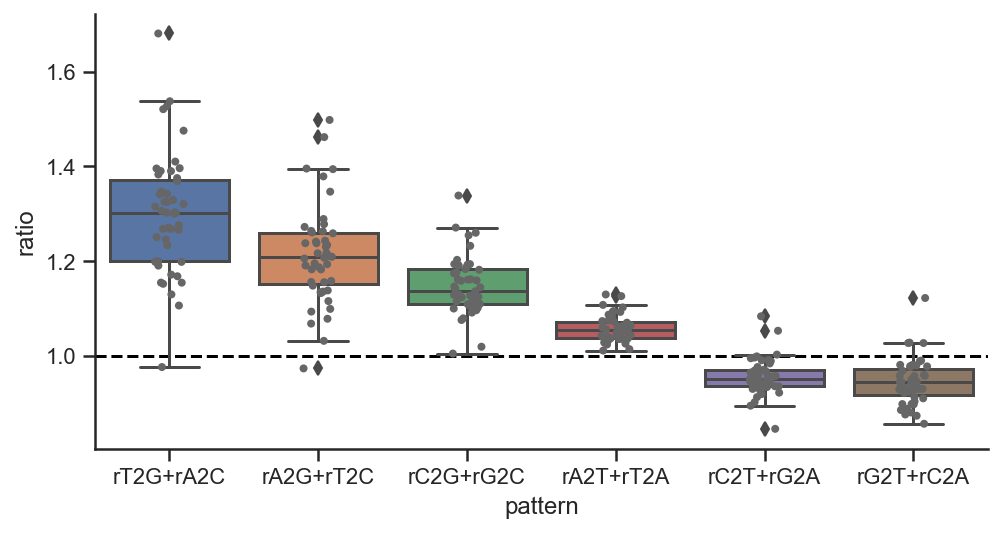

In [29]:
order=['rT2G+rA2C', 'rA2G+rT2C', 'rC2G+rG2C', 'rA2T+rT2A', 'rC2T+rG2A', 'rG2T+rC2A']
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.stripplot(x="pattern", y="ratio", jitter=True, data=plot_df, 
                  color='#666666', ax=ax, size=4, order=order)
    sns.boxplot(x="pattern", y="ratio", data=plot_df, ax=ax, order=order)
    sns.despine()
    plt.axhline(y=1, linestyle='dashed', color='black', zorder=0)
    plt.savefig(figures_path / 'all_paired_subst_rates_boxplot.pdf')                                                        

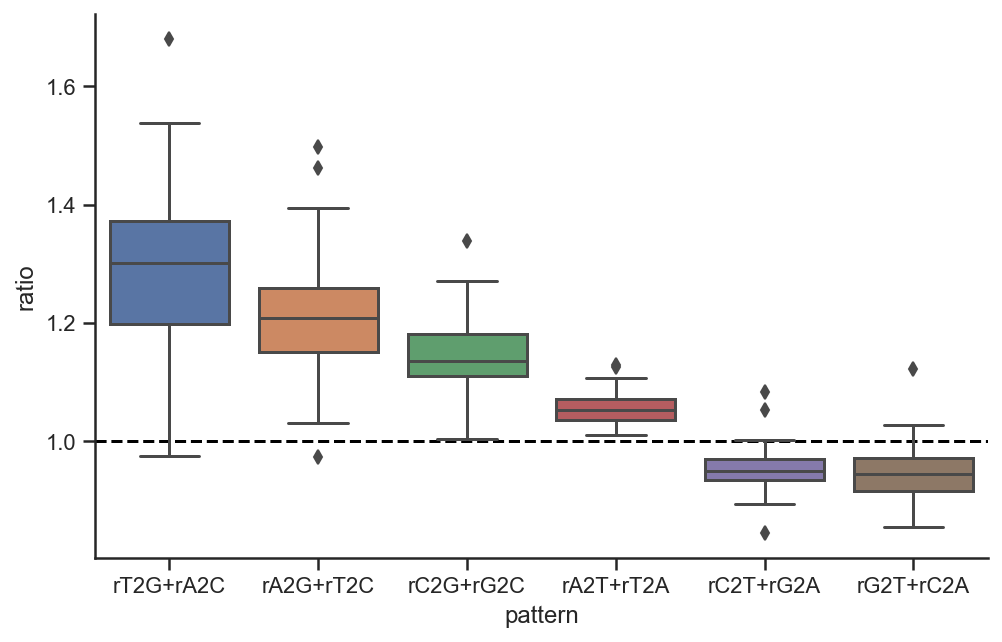

In [30]:
order=['rT2G+rA2C', 'rA2G+rT2C', 'rC2G+rG2C', 'rA2T+rT2A', 'rC2T+rG2A', 'rG2T+rC2A']
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.boxplot(x="pattern", y="ratio", data=plot_df, ax=ax, order=order)
    sns.despine()
    plt.axhline(y=1, linestyle='dashed', color='black', zorder=0)
    plt.savefig(figures_path / 'poster_all_paired_subst_rates_boxplot.pdf') 

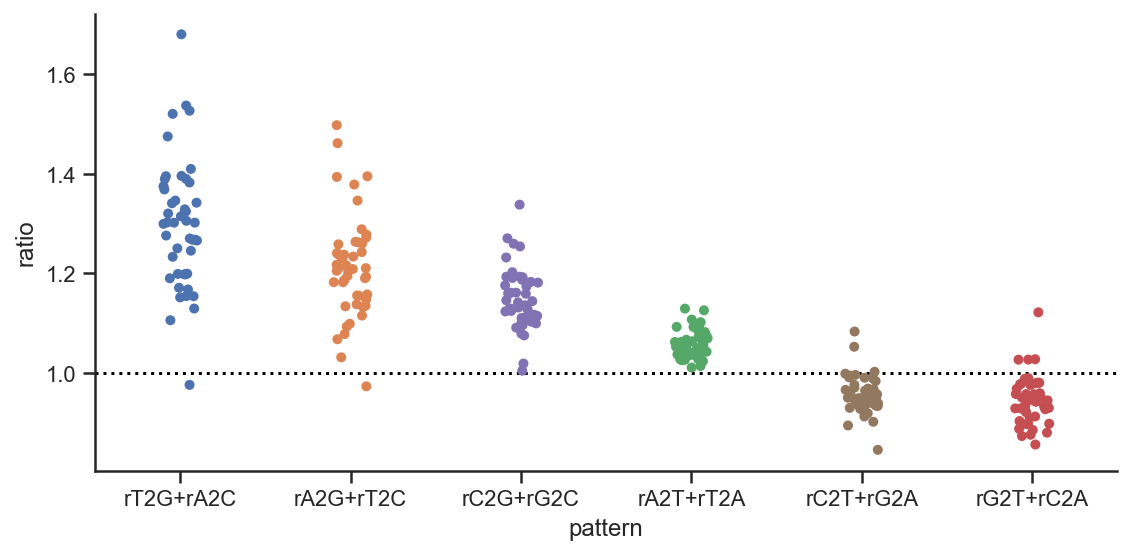

In [31]:
order=['rT2G+rA2C', 'rA2G+rT2C', 'rC2G+rG2C', 'rA2T+rT2A', 'rC2T+rG2A', 'rG2T+rC2A']
with sns.axes_style('ticks'):
    g = sns.catplot(x="pattern", y="ratio", #col='species',# col_wrap=5, 
                  jitter=True, data=plot_df, hue='pattern',
                  height=4, aspect=2,
                  order=order
               )
    g.map(plt.axhline, y=1, linestyle='dotted', color='black', zorder=0)
    plt.savefig(figures_path / 'poster_all_subst_rates_stripplot.pdf')  

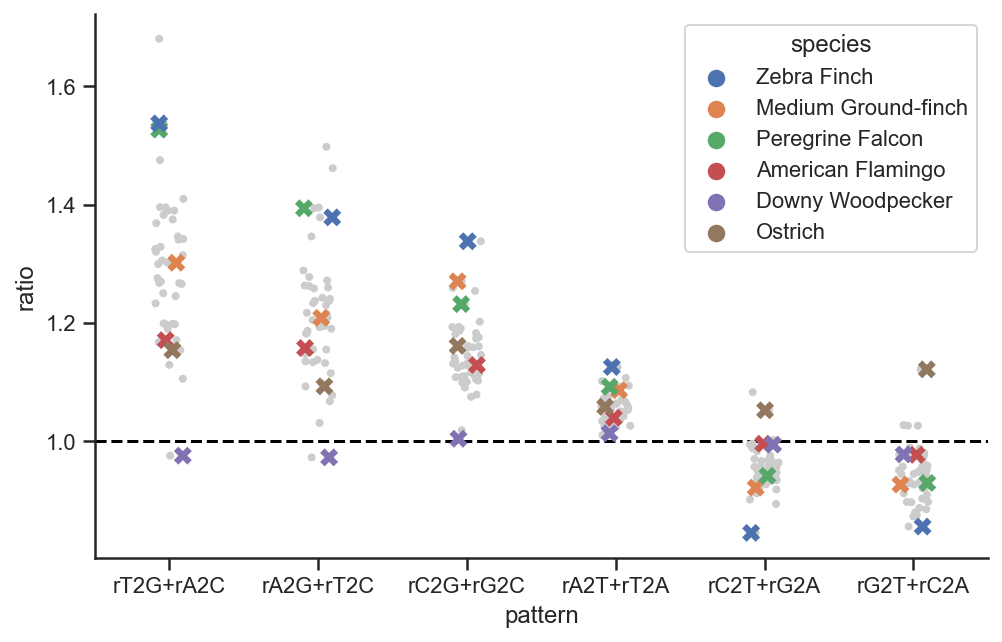

In [32]:
order=['rT2G+rA2C', 'rA2G+rT2C', 'rC2G+rG2C', 'rA2T+rT2A', 'rC2T+rG2A', 'rG2T+rC2A']
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8, 5))
    np.random.seed(42)
    sns.stripplot(x="pattern", y="ratio", jitter=True, data=plot_df, 
                  color='#cccccc', ax=ax, size=4, order=order)
    np.random.seed(42)
    plot_df_subset = plot_df.copy()
    plot_df_subset = plot_df_subset.loc[plot_df_subset.species.isin(example_species)]
    plot_df_subset['species'] = plot_df_subset.species.cat.remove_unused_categories()
    sns.stripplot(x="pattern", y="ratio", jitter=True, hue='species', marker='X', data=plot_df_subset, 
                 ax=ax, size=9, order=order, hue_order=example_species, zorder=10)
    sns.despine()
    plt.axhline(y=1, linestyle='dashed', color='black', zorder=0)
    plt.savefig(figures_path / 'poster_all_subst_rates_stripplot_example_species.pdf')  